# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

## Подготовка

### Импорт библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer 

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import time

from sklearn.metrics import f1_score

from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_colwidth', 100)
sns.set(rc={'figure.figsize':(15,4)}, style='white')

!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator

### Датафрейм

Прочитаем датафрейм с комментариями в файл

In [2]:
df = pd.read_csv('/datasets/toxic_comments.csv')

Посмотрим информацию о файле

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Посмотрим первые пять строк файла

In [4]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They wer...,0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, Januar...",0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relev...",0
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics...",0
4,"You, sir, are my hero. Any chance you remember what page that's on?",0


Посмотрим, какие комментарии отмечены как токсичные

In [5]:
df.query('toxic == 1').head()

,text,toxic
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
12,Hey... what is it..\n@ | talk .\nWhat is it... an exclusive group of some WP TALIBANS...who are ...,1
16,"Bye! \n\nDon't look, come or think of comming back! Tosser.",1
42,"You are gay or antisemmitian? \n\nArchangel WHite Tiger\n\nMeow! Greetingshhh!\n\nUh, there are ...",1
43,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1


### Облако слов

Воспользуемся библиотекой wordcloud для построения облака слов

In [6]:
normal_words = df[df.toxic==0]
toxic_words = df[df.toxic==1]

In [7]:
all_words = " ".join(review for review in df.text)
normal_words = " ".join(review for review in normal_words.text)
toxic_words = " ".join(review for review in toxic_words.text)

In [8]:
wordcloud_all = WordCloud(max_font_size=50, max_words=100, background_color="black").generate(all_words)
wordcloud_normal = WordCloud(max_font_size=50, max_words=100, background_color="black").generate(normal_words)
wordcloud_toxic = WordCloud(max_font_size=50, max_words=100, background_color="black").generate(toxic_words)

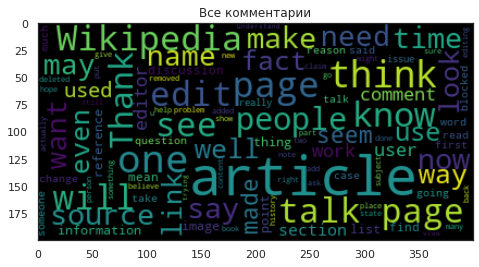

In [9]:
plt.title('Все комментарии')
plt.imshow(wordcloud_all, interpolation='bilinear')

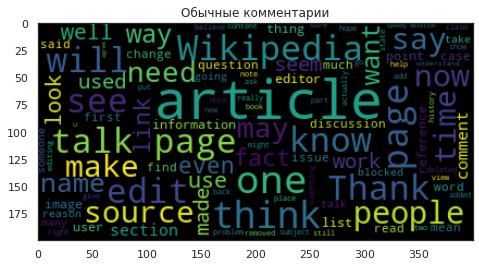

In [10]:
plt.title('Обычные комментарии')
plt.imshow(wordcloud_normal, interpolation='bilinear')

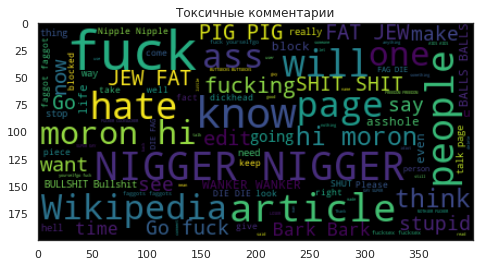

In [11]:
plt.title('Токсичные комментарии')
plt.imshow(wordcloud_toxic, interpolation='bilinear')

### Подготовка текста

Скопируем тексты в другой столбец

In [12]:
df['original'] = df['text'].copy()
df = df.reindex(columns=['toxic', 'original', 'text'])

Проведем предобработку текста - удалим из текстов символы и числа, и приведем к нижнему регистру, а также проведем токенизацию (разбиение текста на токены)

In [13]:
def remove_symbols(text):
    return re.sub(r'[\W\d]\s*', ' ', text).lower()

In [14]:
df.text = df.text.apply(remove_symbols)

In [15]:
def tokenize(text):
    return re.split(' ', text)

In [16]:
df.text = df.text.apply(tokenize)

Удалим образовавшиеся после токенизации пустые строки

In [17]:
def remove_empty(text):
    return [word for word in text if word!='']

In [18]:
df.text = df.text.apply(remove_empty)

Удалим из текстов стоп-слова (слова, не несущие значения)

In [19]:
stopwords_list = stopwords.words('english')
def remove_stopwords(text):
    return [word for word in text if word not in stopwords_list]

In [20]:
df.text = df.text.apply(remove_stopwords)

Лемматизируем тексты (приведем словоформы к первоначальной форме - лемме)

In [21]:
lemmatizer = WordNetLemmatizer()

def lemmatize(text):
    return [lemmatizer.lemmatize(word) for word in text]

In [22]:
df.text = df.text.apply(lemmatize)

Посмотрим получившийся результат

In [23]:
df.head()

,toxic,original,text
0,0,Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They wer...,"[explanation, edits, made, username, hardcore, metallica, fan, reverted, vandalism, closure, gas..."
1,0,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, Januar...","[aww, match, background, colour, seemingly, stuck, thanks, talk, january, utc]"
2,0,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relev...","[hey, man, really, trying, edit, war, guy, constantly, removing, relevant, information, talking,..."
3,0,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics...","[make, real, suggestion, improvement, wondered, section, statistic, later, subsection, type, acc..."
4,0,"You, sir, are my hero. Any chance you remember what page that's on?","[sir, hero, chance, remember, page]"


## Обучение

### Подготовка признаков

Разделим датафрейм на обучающую и тестовую выборки в соотношении 70:30

In [24]:
train, test = train_test_split(df, test_size=0.3, random_state=12345)

Создадим счетчик TF-IDF

In [25]:
count_tf_idf = TfidfVectorizer()

Разделим признаки в выборках

In [26]:
features_train = train['text'].astype('U')
target_train = train['toxic']
    
features_test = test['text'].astype('U')
target_test = test['toxic']

Применим на признаках TF-IDF

In [27]:
features_train = count_tf_idf.fit_transform(features_train)
features_test = count_tf_idf.transform(features_test)

### Функции для обучения

Определим функции, которые будем использовать при обучении

Обучение модели и расчет времени

In [28]:
def fit_model(model, features, target):
    start = time.time()
    
    try:
        model.fit(features, target, verbose=False)
    except:
        model.fit(features, target)
        
    end = time.time()
    
    return {'model':model, 'fit_time':(end-start)}

Предсказание целевого признака и расчет времени

In [29]:
def predict_values(model, features):
    start = time.time()
    
    predictions = model.predict(features)
    end = time.time()
    
    return {'predictions':predictions, 'prediction_time':(end-start)}

Вывод метрик

In [30]:
def display_metrics(fit_time, prediction_time, f1_score):
    print('Время обучения модели:', fit_time)
    print('Время предсказания:', prediction_time)
    print('F1 Score:', f1_score)

Обработка модели

In [31]:
def process_model(model, features_train, target_train, features_test, target_test):
    fit = fit_model(model, features_train, target_train)
    predict = predict_values(fit.get('model'), features_test)
    f1 = f1_score(target_test, predict.get('predictions'))
    display_metrics(fit.get('fit_time'), predict.get('prediction_time'), f1)
    return [fit.get('model'), fit.get('fit_time'), predict.get('prediction_time'), f1]

### Обучение моделей

Обучим классификаторы и логистическую регрессию без подбора гиперпараметров, сравним результаты и выберем лучшую модель

In [32]:
models = []

LogisticRegression

In [33]:
model = LogisticRegression()
models.append(process_model(model, features_train, target_train, features_test, target_test))

Время обучения модели: 46.47535967826843
Время предсказания: 0.004828691482543945
F1 Score: 0.7453096259963213


DecisionTreeClassifier

In [34]:
model = DecisionTreeClassifier()
models.append(process_model(model, features_train, target_train, features_test, target_test))

Время обучения модели: 320.39359736442566
Время предсказания: 0.14385390281677246
F1 Score: 0.7107183228856233


RandomForestClassifier

In [35]:
model = RandomForestClassifier()
models.append(process_model(model, features_train, target_train, features_test, target_test))

Время обучения модели: 422.2914969921112
Время предсказания: 7.2004148960113525
F1 Score: 0.7255999005346264


Результаты

In [36]:
result = pd.DataFrame(models, columns=['model','fit_time','prediction_time','f1_score'])

In [37]:
result.style.background_gradient(cmap='YlGnBu')

,model,fit_time,prediction_time,f1_score
0,LogisticRegression(),46.475360,0.004829,0.745310
1,DecisionTreeClassifier(),320.393597,0.143854,0.710718
2,RandomForestClassifier(),422.291497,7.200415,0.725600


Лучший результат демонстрирует логистическая регрессия, у дерева и леса результаты неплохие, но очень долгое время обучения, у байесовского классификатора результат посредственный

Попробуем улучшить результаты

Посмотрим соотношение комментариев

In [38]:
data = df.toxic.value_counts()
labels = data.index

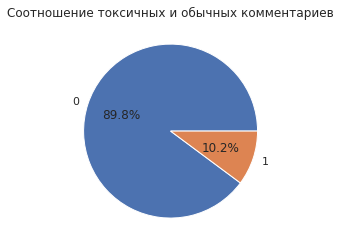

In [39]:
plt.pie(data, labels=labels, autopct='%.1f%%')
plt.title('Соотношение токсичных и обычных комментариев')
plt.show()

Налицо дисбаланс классов, нужно переобучить модели с учетом дисбаланса, а также попробовать уменьшить глубину для деревьев, чтобы снизить время обучения. Для модели логистической регрессии имеет смысл увеличить гиперпараметр C (по умолчанию 1.0)

LogisticRegression

In [40]:
model = LogisticRegression(class_weight='balanced', C=2)
models.append(process_model(model, features_train, target_train, features_test, target_test))

Время обучения модели: 46.91940093040466
Время предсказания: 0.005694389343261719
F1 Score: 0.7674718790337451


DecisionTreeClassifier

In [41]:
model = DecisionTreeClassifier(class_weight='balanced', max_depth=10)
models.append(process_model(model, features_train, target_train, features_test, target_test))

Время обучения модели: 5.565413951873779
Время предсказания: 0.010372638702392578
F1 Score: 0.5766031660853234


RandomForestClassifier

In [42]:
model = RandomForestClassifier(class_weight='balanced', max_depth=10)
models.append(process_model(model, features_train, target_train, features_test, target_test))

Время обучения модели: 3.4750802516937256
Время предсказания: 0.6442663669586182
F1 Score: 0.3571091166745395


## Выводы

Представленный датафрейм содержит текстовые комментарии и оценку, является ли комментарий токсичным

Проведена предобработка текста:
1. Удалены символы и числа
2. Тексты приведены к нижнему регистру
3. Применена токенизация
4. Удалены стоп-слова
5. Применена лемматизация

После предобработки датафрейм был разделен на обучающую и тестовую выборки в соотношении 70:30, после чего к текстам была применена векторизация TF-IDF

Так как задача сводилась к классификации 0-1, выбраны следующие модели машинного обучения:
1. Логистическая регрессия
2. Классификатор "дерево решений"
3. Классификатор "случайный лес"

После обучения получены следующие результаты:
1. Самой перспективной представляется логистическая регрессия - самая высокая метрика F1 при быстром обучении
2. Дерево решений и случайный лес имеют неплохую F1, но крайне медленно обучаются

После этого был проверен баланс классов и выявлен дисбаланс

Модели были переобучены с учетом дисбаланса, а у моделей случайного леса и дерева решений глубина была ограничена 10, также у логистической модели был увеличен параметр C

После переобучения следующие результаты:
1. Дерево и лес обучились значительно быстрее, но метрика F1 упала до неприемлемых значений
2. Логистическая регрессия получила F1=0.767 при незначительном увеличении времени обучения